In [167]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from  av.io import read
import pandas as pd
import datetime
import tensorflow as tf
#tf.enable_eager_execution()


from sklearn.preprocessing import normalize
from tensorflow import keras



In [168]:
use_rotation_sensor = False
if use_rotation_sensor:
    cut_shape = (100, 8)
    normalize_vector = np.array([1,1,1,1,1, 15, 15, 15])
else:
    cut_shape = (100, 3)
    normalize_vector = np.array([15, 15, 15])
gestures = {0: 'Noise', 1: 'Left', 2: 'Right'}

In [169]:
def read_file(filename, lable=None):
    data, meta = read(" ".join(["a:" + str(i) for i in range(4)]), filename, 50)
    datapairs = list(zip(data, meta))
    
    df = pd.DataFrame()
    names = []
    col_name_tpls = []
    for sensor_data, stream_object in datapairs:
        meta_dict = stream_object.metadata
        # print(meta_dict)
        name = meta_dict["NAME"]
        names.append(name)
        n_cols = len(sensor_data)
        col_names = []
        for i in range(n_cols):
            col_name = name + "_" + str(i)
            col_names.append(col_name)
            df[col_name] = pd.Series(sensor_data.T[:,i])
        col_name_tpls.append(col_names)
    df.index = pd.TimedeltaIndex(freq="20ms", start=0.0, periods=len(df))
    return df, col_name_tpls

def trim_data(data_frame, start=0.0, end=None):
    if end:
        df = data_frame[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = data_frame[pd.Timedelta(10**9 * start):]
    return df

def cut_data(data_frame, cuts):
    df_cut_list = np.ndarray(shape=(len(cuts),) + cut_shape)
    for i, cut in enumerate(cuts):
        df_i = data_frame[pd.Timedelta(10**9 * cut[0]):pd.Timedelta(10**9 * cut[1])]
        start_chanel = 0
        if not use_rotation_sensor:
            start_chanel = 5
        df_cut_list[i, : , :] = df_i.iloc[0: 100, start_chanel:8]
    return df_cut_list


def find_peaks(df, sensor, start=0.0, end=None, sel_method="right"):
    peaks = []
    if end:
        df = df[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = df[pd.Timedelta(10**9 * start):]

    for i in df.index:
        value = df[sensor][i]
        if sel_method == "right":
            cond = value > 8
        elif sel_method == "left":
            cond = value < -1
        if cond:
            new = True
            for peak in peaks:
                if i - pd.Timedelta(10**9) < peak + pd.Timedelta(10**9):
                    new = False
                    break
            if new:
                peaks.append(i)
    cuts = []
    for peak in peaks:
        t = peak.value / 10 ** 9
        cuts.append((t-1, t+1))
    return cuts 

def normalize_cuts(cuts):
    for i in range(len(cuts)):
        cuts[i, : , :] = cuts[i]/normalize_vector
    return cuts
  

def plot_dataframe(df, col_name_tpls):
    for col_name_tpl in col_name_tpls:
        for col_name in col_name_tpl:
            fig = df[col_name].plot()
            fig.set_title(col_name)
            plt.show()

def plot_cuts(cuts, sensor=None):
    if sensor is None:
        for cut in cuts:
            plt.plot(cut)
            plt.show()
        return
    for cut in cuts:
        cut = cut[sensor]
        cut = cut.values.reshape(-1,1)
        print(cut.shape)
        normed_matrix = normalize(cut, axis=0, norm='l1')
        plt.plot(normed_matrix)
        plt.show()

/home/gende/repos/PyAV/venvs/Linux.4.4.0-17134-Microsoft.cpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


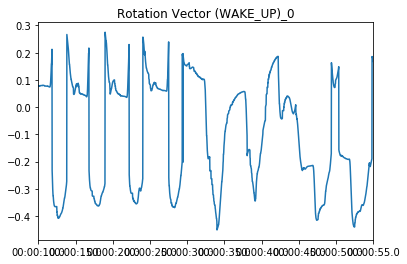

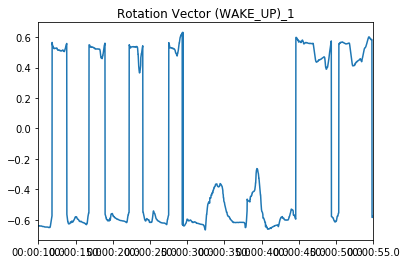

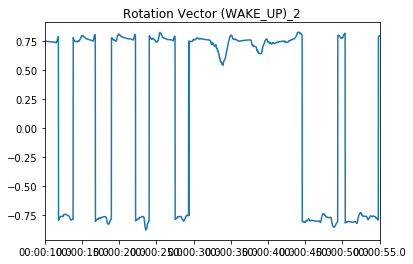

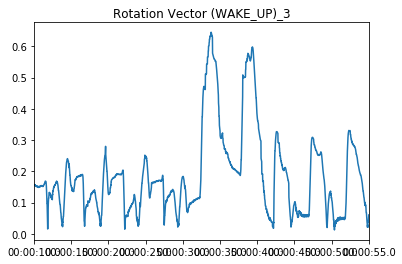

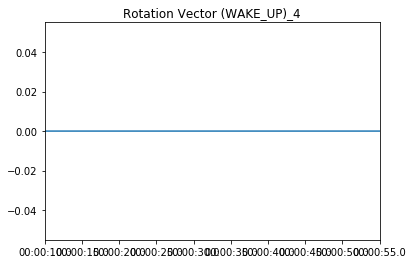

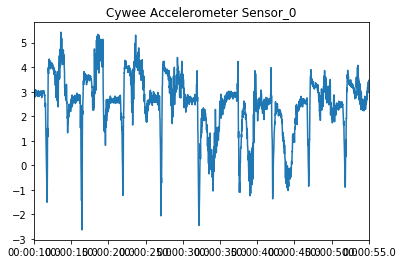

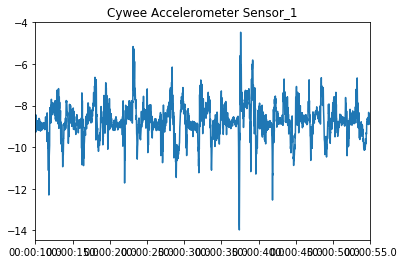

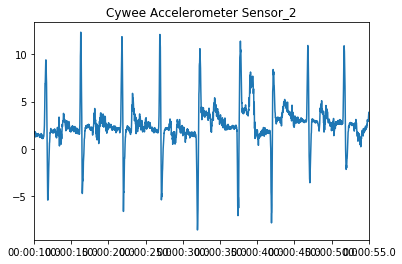

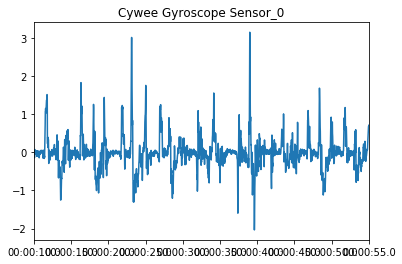

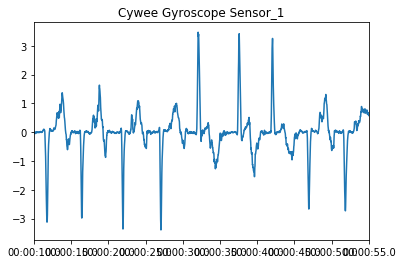

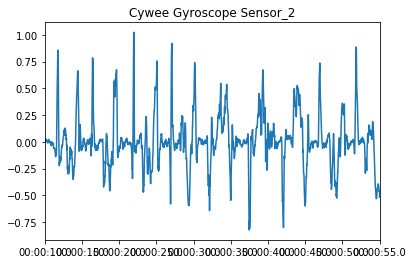

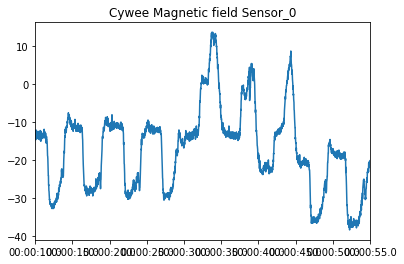

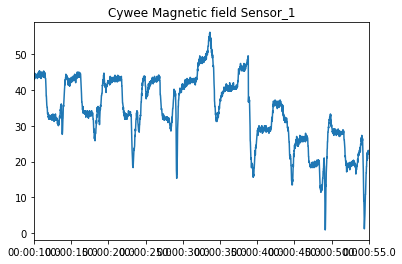

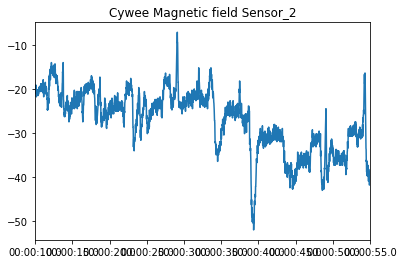

9 : [(10.54, 12.54), (15.239999999999998, 17.24), (20.76, 22.76), (25.86, 27.86), (31.22, 33.22), (36.64, 38.64), (41.14, 43.14), (45.74, 47.74), (50.64, 52.64)]
Found cuts: 9


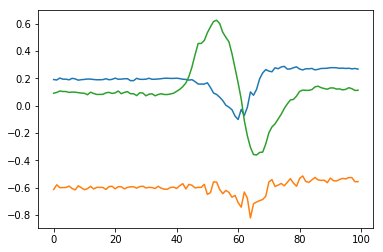

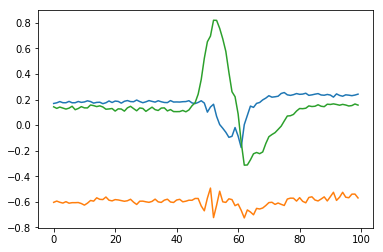

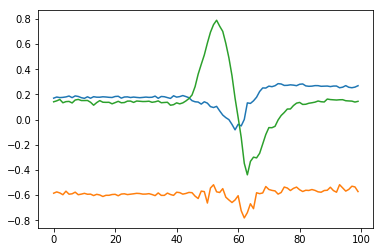

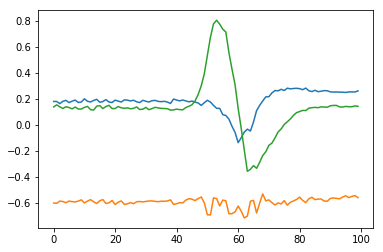

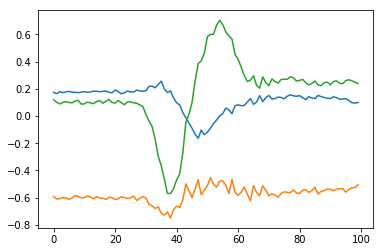

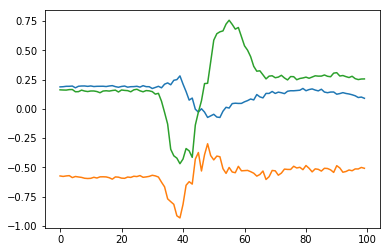

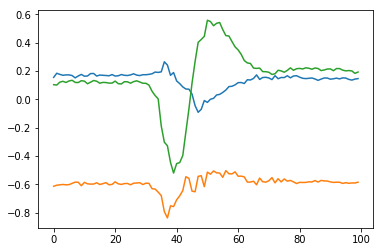

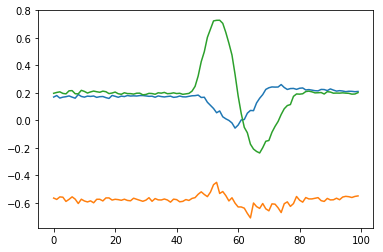

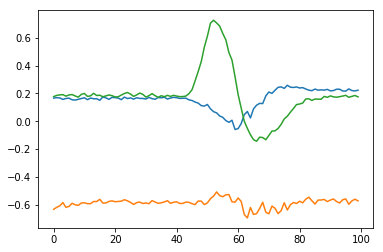

In [170]:
df, col_name_tpls = read_file("swipe_test_both.mkv")
trimed_df = trim_data(df, 10, 55)
plot_dataframe(trimed_df, col_name_tpls)
peaks = find_peaks(trimed_df, "Cywee Accelerometer Sensor_2")
print(len(peaks), ":", peaks)
cuts = normalize_cuts(cut_data(trimed_df, peaks))
print("Found cuts:", len(cuts))
plot_cuts(cuts)

In [171]:
def  learn_clisifyer(data, lables):
    print(data.shape)
    model = keras.Sequential([
        #keras.layers.Flatten(),
        keras.layers.Flatten(input_shape=cut_shape),
        keras.layers.Dense(100 * len(normalize_vector), activation=tf.nn.relu),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    model.fit(data, lables, epochs=50)
    test_loss, test_acc = model.evaluate(data, lables)

    print('Test accuracy:', test_acc)
    
    return model

    



In [172]:
def prepare_learn_set(data_frame, previous_learned_data=None):
    peaks = find_peaks(data_frame, "Cywee Accelerometer Sensor_2")
    cuts = cut_data(data_frame, peaks)
    learn_data = normalize_cuts(cuts) # Normalize
    print("DataShape:", learn_data.shape)
    
    if previous_learned_data is not None:
        learn_data = np.append(learn_data, previous_learned_data, axis=0)
    return learn_data
    
    

# Use Tensorflow to classify gestures

## Learn model


In [173]:
df, col_name_tpls = read_file("swipe_right_10_new.mkv")
trimed_df = trim_data(df, 52, 90)
learn_data_r = prepare_learn_set(trimed_df)

df, col_name_tpls = read_file("swipe_left_10.mkv")
trimed_df = trim_data(df, 10, 57)
learn_data_l = prepare_learn_set(trimed_df)

df, col_name_tpls = read_file("data/swipe_left_20.mkv")
trimed_df = trim_data(df, 15, 90)
learn_data_l = prepare_learn_set(trimed_df, learn_data_l)

df, col_name_tpls = read_file("random_noise.mkv")
trimed_df = trim_data(df, 0)
cuts = cut_data(trimed_df, [(i * 2, i*2+2) for i in range(50)])
learn_data_noise = normalize_cuts(cuts)
print("Noiseshape:", learn_data_noise.shape)
print("Learn L shape:", learn_data_l.shape)

learn_data = np.append(learn_data_noise, learn_data_l, axis=0)
learn_data = np.append(learn_data, learn_data_r, axis=0)

lables = [0]*len(learn_data_noise) + [1]*len(learn_data_l) + [2]*len(learn_data_r)

print("Learn data has shape: {}".format(learn_data.shape))
model = learn_clisifyer(learn_data, lables)


/home/gende/repos/PyAV/venvs/Linux.4.4.0-17134-Microsoft.cpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


DataShape: (9, 100, 3)
DataShape: (9, 100, 3)
DataShape: (18, 100, 3)
Noiseshape: (50, 100, 3)
Learn L shape: (27, 100, 3)
Learn data has shape: (86, 100, 3)
(86, 100, 3)
Epoch 1/50
86/86 [==============================] - 0s 3ms/sample - loss: 1.0193 - acc: 0.4070
Epoch 2/50
86/86 [==============================] - 0s 272us/sample - loss: 0.5735 - acc: 0.8140
Epoch 3/50
86/86 [==============================] - 0s 227us/sample - loss: 0.4596 - acc: 0.8140
Epoch 4/50
86/86 [==============================] - 0s 117us/sample - loss: 0.3642 - acc: 0.8721
Epoch 5/50
86/86 [==============================] - 0s 148us/sample - loss: 0.3143 - acc: 0.9419
Epoch 6/50
86/86 [==============================] - 0s 165us/sample - loss: 0.2688 - acc: 0.9419
Epoch 7/50
86/86 [==============================] - 0s 146us/sample - loss: 0.2298 - acc: 0.9419
Epoch 8/50
86/86 [==============================] - 0s 139us/sample - loss: 0.1962 - acc: 0.9419
Epoch 9/50
86/86 [==============================] - 0s 

# Test learned model
Test data has gestures:
Left, Left, Left, Left, Right, Right, Right, Left, Left

In [174]:
df, col_name_tpls = read_file("swipe_test_both.mkv")
trimed_df = trim_data(df, 10, 55)
test_data = prepare_learn_set(trimed_df) 
test_lables = [1, 1, 1, 1, 2, 2, 2, 1, 1]

predictions = model.predict(test_data)
print('Predicted:')
for i, p in enumerate(predictions):
    print('{}: {} should be {} -> {}'.format(i, gestures[np.argmax(p)], 
                                         gestures[test_lables[i]], np.argmax(p) == test_lables[i]))

print('\nTest if noise will be predicted as noise')
df, col_name_tpls = read_file("data/noise_test.mkv")
trimed_df = trim_data(df, 16, 88)
learn_data_noise = prepare_learn_set(trimed_df)
noise_predictions = model.predict(learn_data_noise)
for p in noise_predictions:
    print(gestures[np.argmax(p)])

/home/gende/repos/PyAV/venvs/Linux.4.4.0-17134-Microsoft.cpython3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Creating a TimedeltaIndex by passing range endpoints is deprecated.  Use `pandas.timedelta_range` instead.


DataShape: (9, 100, 3)
Predicted:
0: Left should be Left -> True
1: Left should be Left -> True
2: Left should be Left -> True
3: Left should be Left -> True
4: Right should be Right -> True
5: Right should be Right -> True
6: Right should be Right -> True
7: Left should be Left -> True
8: Left should be Left -> True

Test if noise will be predicted as noise
DataShape: (18, 100, 3)
Left
Noise
Left
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Noise
Left
Noise
Noise
Left
Left
Noise


In [175]:
for p in predictions:
    print(max(p))

0.9961926
0.9967404
0.9974477
0.99675685
0.9715407
0.9870726
0.9252599
0.99734724
0.99614525


In [176]:
for p in noise_predictions:
    if np.argmax(p) != 0:
        print("classified as left or right with confidence {:.2f}%".format(max(p)*100))
    else:
        print("classified as noise,", max(p))

classified as left or right with confidence 45.65%
classified as noise, 0.94054383
classified as left or right with confidence 54.12%
classified as noise, 0.504875
classified as noise, 0.72706157
classified as noise, 0.54956454
classified as noise, 0.47986773
classified as noise, 0.5011808
classified as noise, 0.50097114
classified as noise, 0.50157773
classified as noise, 0.49317494
classified as noise, 0.5686729
classified as left or right with confidence 63.15%
classified as noise, 0.9501971
classified as noise, 0.5772439
classified as left or right with confidence 47.25%
classified as left or right with confidence 66.95%
classified as noise, 0.4717453


In [177]:
import sklearn.svm

In [204]:
for split in range(15,101, 15):
    print(split-15, split+10)

0 25
15 40
30 55
45 70
60 85
75 100


In [208]:
def get_features(tf_learn_data, mode="features"):
    out_data = []
    for learn_data in tf_learn_data:
        feature_vec = []
        for split in range(15,101, 15):
            cur_split = learn_data[split-15:split+10]
            for i in range(3):
                sensor_data  = cur_split[:,i]
                feature_vec.append(sensor_data.mean())
                feature_vec.append(sensor_data.max())
                feature_vec.append(sensor_data.min())
                feature_vec.append(np.median(sensor_data))
        if mode == "features":
            out_data.append(feature_vec)
        elif mode == "raw":
            out_data.append(learn_data.flatten())
    return np.array(out_data)

In [212]:
X_train = get_features(learn_data)
y = lables

X_test = test_data
y_test = test_lables


clf = sklearn.svm.SVC(gamma=1.0, decision_function_shape='ovo')
clf.fit(X_train, y) 
predictions = clf.predict(get_features(test_data))

print('Predicted:')
for i, p in enumerate(predictions):
    print('{}: {} should be {} -> {}'.format(i, gestures[p], 
                                         gestures[y_test[i]], p == y_test[i]))

    
print(clf.predict(get_features(learn_data_noise)))

Predicted:
0: Left should be Left -> True
1: Left should be Left -> True
2: Left should be Left -> True
3: Left should be Left -> True
4: Right should be Right -> True
5: Right should be Right -> True
6: Right should be Right -> True
7: Left should be Left -> True
8: Left should be Left -> True
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [207]:
X_train.shape

(86, 72)